# **Download the dataset**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

# **Importing the libraries**

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 
plt.style.use('seaborn-white') 

from tensorflow.keras.utils import plot_model
import random
from PIL import Image
import glob
import seaborn as sns
from tqdm.notebook import tqdm
import time

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve,auc, accuracy_score, confusion_matrix, classification_report

import tensorflow
from keras.applications import EfficientNetB0, DenseNet121, DenseNet169, DenseNet201, InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

/tmp/ipykernel_23/1713714160.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# **Load images and assign class**

In [3]:
train_path = "../input/brain-tumor-classification-mri/Training"
test_path = "../input/brain-tumor-classification-mri/Testing"

classes = ['no_tumor','pituitary_tumor', 'meningioma_tumor','glioma_tumor']
#classes.index('no_tumor')

X_train = []
Y_train = []
# Function to load images and assign a class
def load_data(directory):
    for class_name in tqdm(os.listdir(directory),desc=directory):
        class_path = os.path.join(directory, class_name)
        class_label = class_name
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            X_train.append(img)
            Y_train.append(classes.index(class_name))
    return X_train,Y_train
X_train , Y_train = load_data(train_path)
X_train , Y_train = load_data(test_path)

../input/brain-tumor-classification-mri/Training:   0%|          | 0/4 [00:00<?, ?it/s]

../input/brain-tumor-classification-mri/Testing:   0%|          | 0/4 [00:00<?, ?it/s]

# **Distribution of Classes**

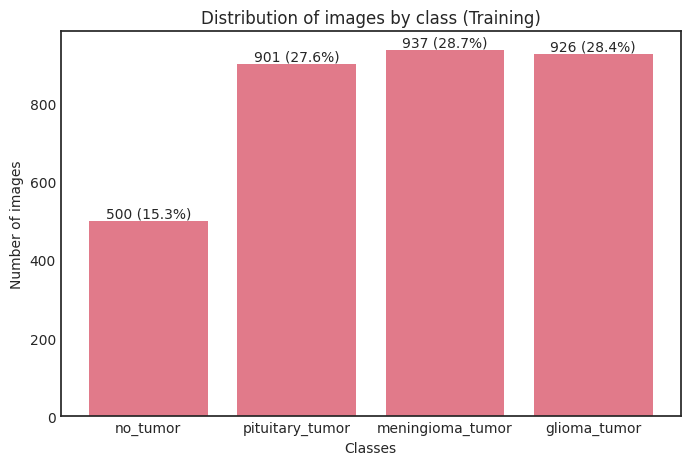

In [4]:
# Function to count the number of images per class
def count_images_per_class(data, classes):
    count_per_class = {class_name: 0 for class_name in classes}
    for class_idx in data:
        class_name = classes[class_idx]
        count_per_class[class_name] += 1
    return count_per_class

# Count the number of images per class for the training and test sets
train_count_per_class = count_images_per_class(Y_train, classes)

plt.figure(figsize=(8, 5))
#train  data
train_bars = plt.bar(train_count_per_class.keys(), train_count_per_class.values(), color='#E17A8A')
plt.title('Distribution of images by class (Training)')
plt.xlabel('Classes')
plt.ylabel('Number of images')
# Add the percentages
for bar in train_bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height} ({height / np.sum(list(train_count_per_class.values())) * 100:.1f}%)', ha='center', va='bottom', fontsize=10)

plt.show()

# **5 images for each class**

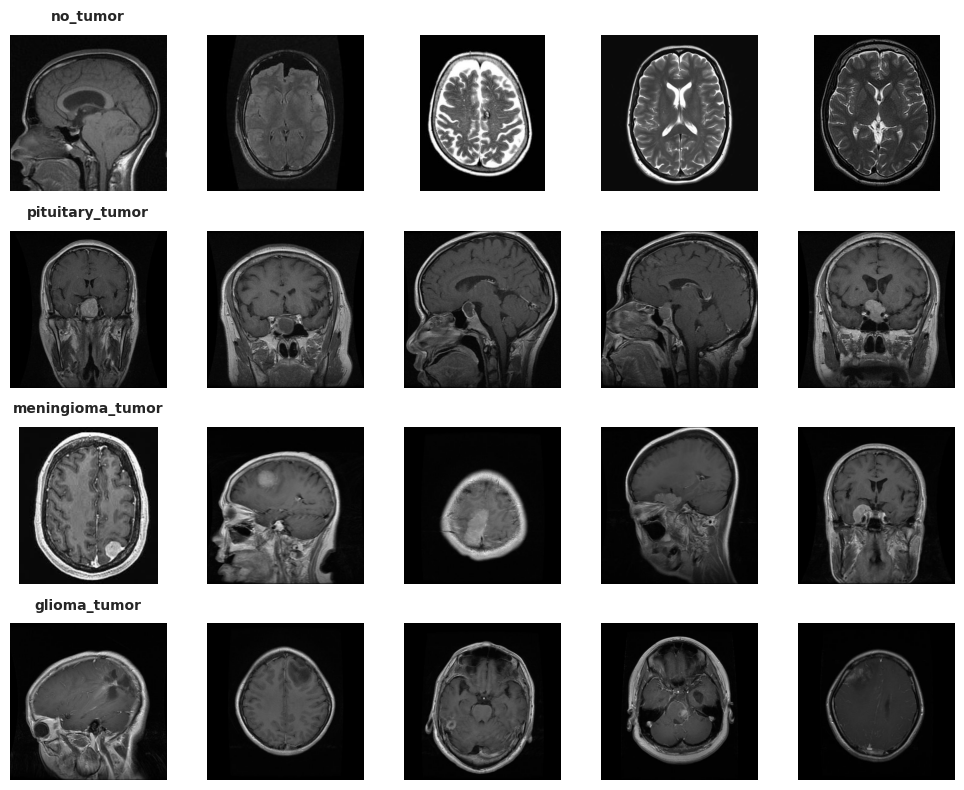

In [5]:
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display example images for each class
show_examples(X_train, Y_train, classes)

# **Most common image sizes**

In [6]:
train_data_shapes = []
for img in X_train:
  train_data_shapes.append(img.shape)
# Count the occurrences for each size
shape_counts = {}
for shape in train_data_shapes:
  if shape not in shape_counts:
    shape_counts[shape] = 0
  shape_counts[shape] += 1
# Sort the shapes by count
sorted_shapes = sorted(shape_counts.items(), key=lambda x: x[1], reverse=True)
# Display the most frequent size
print("Most frequent Train images shapes:")
for shape, count in sorted_shapes[:3]:
  print(f"- {shape}: {count}")

Most frequent Train images shapes:
- (512, 512, 3): 2341
- (236, 236, 3): 79
- (225, 225, 3): 43


In [7]:
shape = (225, 225, 3)

# **Data Preparation**

In [8]:
# Function to crop an image
def crop_image(image):
    # Convert the image to grayscale
    if len(image.shape) == 3: 
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:  
        gray = image.copy()

    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    largest_contour = max(contours, key=cv2.contourArea)

    cropped_image = image[cv2.boundingRect(largest_contour)[1]:cv2.boundingRect(largest_contour)[1] + cv2.boundingRect(largest_contour)[3], cv2.boundingRect(largest_contour)[0]:cv2.boundingRect(largest_contour)[0] + cv2.boundingRect(largest_contour)[2]]

    return cropped_image

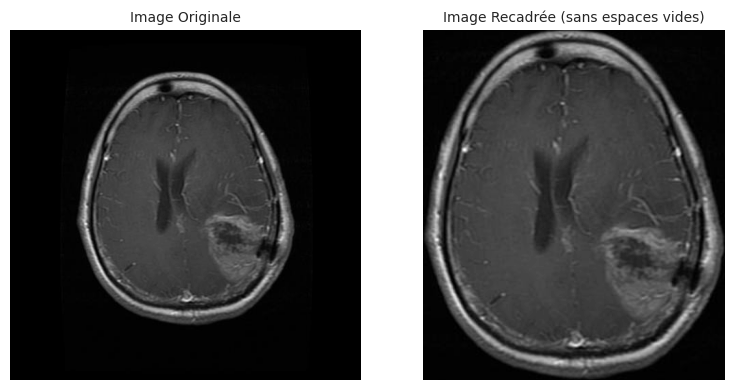

In [9]:
# Only for testing the crop_image function
image_path = "../input/brain-tumor-classification-mri/Testing/glioma_tumor/image(67).jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

cropped_image = crop_image(img)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title("Image Originale", fontsize=10)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cropped_image, cmap='gray')
plt.title("Image Recadrée (sans espaces vides)", fontsize=10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
#Crop, normalize, and resize all images
def preprocess_data(train_data):
  processed_data = []
  for img in tqdm(train_data):

    cropped_img = crop_image(img)

    resized_img = cv2.resize(cropped_img, (shape[1], shape[0]))

    normalized_img = cv2.normalize(resized_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    processed_data.append(normalized_img)

  return processed_data

X_train = preprocess_data(X_train)

X_train = np.array(X_train)

  0%|          | 0/3264 [00:00<?, ?it/s]

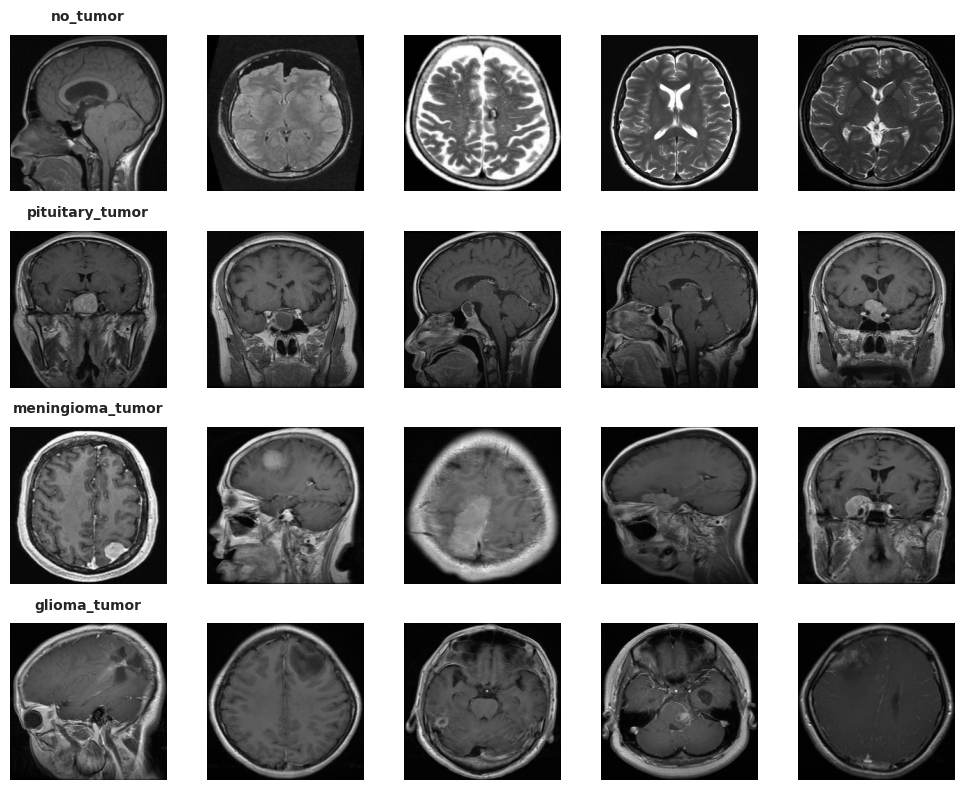

In [11]:
# Function to display example images for each class after preprocessing
def show_examples(X_data, Y_data, classes, num_examples=5):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, num_examples, figsize=(10, 8))
    
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, label in enumerate(Y_data) if label == i]
        axs[i, 0].set_title(class_name, fontsize=10, pad=10, fontweight='bold')
        for j in range(num_examples):
                img = X_data[class_indices[j]]
                axs[i, j].imshow(img)
                axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

show_examples(X_train, Y_train, classes)

# **Train and test split**

In [12]:
X_train, Y_train = shuffle(X_train,Y_train, random_state=64)

In [13]:
# Split the training set into training and test sets
X_train,X_test,Y_train,Y_test = train_test_split(X_train,Y_train, test_size=0.3,random_state=64)

In [14]:
# Split the test set into validation and test sets
X_test,X_val,Y_test,Y_val = train_test_split(X_test,Y_test, test_size=2/3,random_state=64)

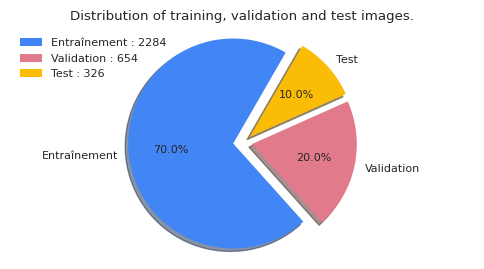

In [15]:
sizes = [len(Y_train), len(Y_val), len(Y_test)]
labels = ['Entraînement', 'Validation', 'Test']
colors = ['#4285f4', '#E17A8A', '#fbbc05']

plt.figure(figsize=(6,3))
plt.rcParams.update({'font.size': 8})
patches, texts, autotexts = plt.pie(sizes,labels=labels,colors=colors, autopct='%.1f%%', explode=(0.1,0.08,0.08), shadow=True, startangle=60);
plt.title(f"Distribution of training, validation and test images.")
plt.legend(patches, [f"{label} : {size}" for label, size in zip(labels, sizes)], loc="best")
plt.axis('equal') 
plt.show()

# **One Hot Encoding**

In [16]:
Y_train =  np.array(tensorflow.keras.utils.to_categorical(Y_train))
Y_val =  np.array(tensorflow.keras.utils.to_categorical(Y_val))
Y_test =  np.array(tensorflow.keras.utils.to_categorical(Y_test))

# **Data augmentation**

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.2,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

In [18]:
train_generator = train_datagen.flow(
    x=np.array(X_train),
    y=np.array(Y_train)
)

# **Visualization of some examples of an augmented image**

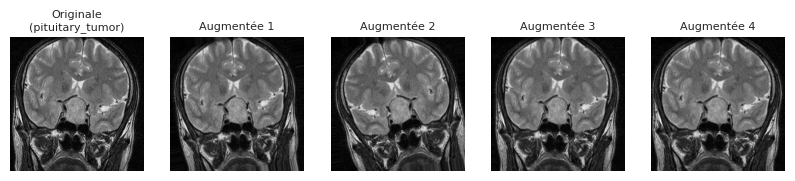

In [19]:
 random_index = np.random.randint(len(X_train))
image = X_train[random_index]
class_label_encoded = Y_train[random_index]
class_label = classes[np.argmax(class_label_encoded)]

# Display the original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 5, 1)
plt.imshow(image)
plt.title('Originale\n({})'.format(class_label), fontsize=8)
plt.axis('off')


for i in range(4):
    augmented_image = train_datagen.random_transform(image)
    plt.subplot(1, 5, i + 2)
    plt.imshow(augmented_image)
    plt.title('Augmentée {}'.format(i + 1), fontsize=8)
    plt.axis('off')

plt.show()

# **Batch Size and Epoch**

In [20]:
batch_size = 64
image_shape = shape
epochs = 30

print(f'Batch size: {batch_size}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')

Batch size: 64
Image shape: (225, 225, 3)
Epochs: 30


# **Custom CNN Model**

In [21]:
CNN_model = Sequential()
CNN_model.add(Conv2D(16, (3,3), activation='relu', input_shape=shape))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(32, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(64, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Conv2D(512, (3,3), activation='relu'))
CNN_model.add(MaxPooling2D(2,2))
CNN_model.add(Dropout(0.2))

CNN_model.add(Flatten())
CNN_model.add(Dense(512, activation='relu'))
CNN_model.add(Dropout(0.5))

CNN_model.add(Dense(len(classes), activation='softmax'))

CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])
CNN_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 223, 223, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,243,940 (27.63 MB)

 Trainable params: 7,243,940 (27.63 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
reduce_lr_cnn = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, min_delta=0.0001, verbose=1) 
early_stop_cnn = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)  
checkpoint_cnn = ModelCheckpoint(filepath='best_CNNModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1)  

In [23]:
# Train the model
start_time_cnn = time.time()
CNN_history = CNN_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr_cnn, early_stop_cnn, checkpoint_cnn],
    verbose=1
)
end_time_cnn = time.time()

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734843885.554967     100 service.cc:145] XLA service 0x7f11bf7b4370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734843885.555032     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734843885.555037     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/72 ━━━━━━━━━━━━━━━━━━━━ 19:40 17s/step - accuracy: 0.1875 - loss: 1.4068 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1734843897.513590     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.2844 - loss: 1.4248 - precision: 0.3530 - recall: 0.0204
Epoch 1: val_accuracy improved from -inf to 0.27523, saving model to best_CNNModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 50s 470ms/step - accuracy: 0.2844 - loss: 1.4237 - precision: 0.3530 - recall: 0.0200 - val_accuracy: 0.2752 - val_loss: 1.3779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.2989 - loss: 1.3475 - precision: 0.0059 - recall: 1.2599e-05    
Epoch 2: val_accuracy did not improve from 0.27523
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 262ms/step - accuracy: 0.2992 - loss: 1.3471 - precision: 0.0096 - recall: 2.4249e-05 - val_accuracy: 0.2752 - val_loss: 1.5418 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3387 - loss: 1.2808 - precision: 0.3670 - recall: 0.0238
Epoch 3: val_accuracy did 

In [24]:
runtime_cnn = end_time_cnn - start_time_cnn
hours_cnn = int(runtime_cnn / 3600)
minutes_cnn = int((runtime_cnn % 3600) / 60)
seconds_cnn = int(runtime_cnn % 60)

print("Total runtime:", hours_cnn, "hours,", minutes_cnn, "minutes,", seconds_cnn, "seconds")

Total runtime: 0 hours, 11 minutes, 3 seconds


In [25]:
CNN_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

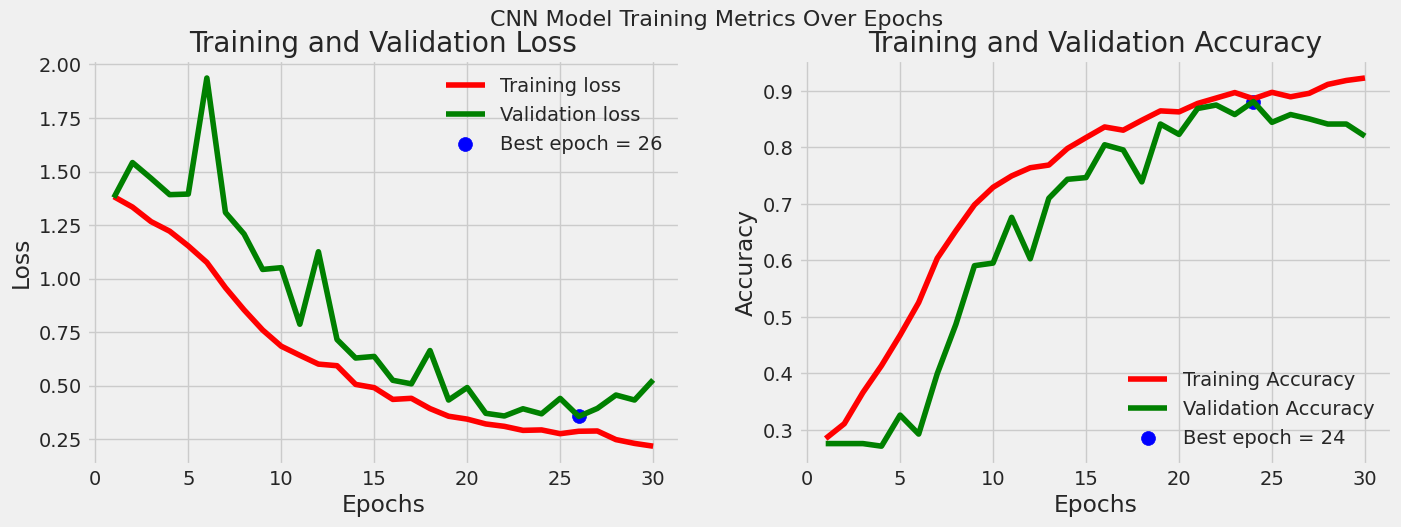

In [31]:
tr_acc_cnn = CNN_history.history['accuracy']
tr_loss_cnn = CNN_history.history['loss']
val_acc_cnn = CNN_history.history['val_accuracy']
val_loss_cnn = CNN_history.history['val_loss']

index_loss_cnn = np.argmin(val_loss_cnn)
val_lowest_cnn = val_loss_cnn[index_loss_cnn]
index_acc_cnn = np.argmax(val_acc_cnn)
acc_highest_cnn = val_acc_cnn[index_acc_cnn]

Epochs = [i + 1 for i in range(len(tr_acc_cnn))]
loss_label_cnn = f'Best epoch = {str(index_loss_cnn + 1)}'
acc_label_cnn = f'Best epoch = {str(index_acc_cnn + 1)}'

plt.figure(figsize=(15, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss_cnn, 'r', label='Training loss')
plt.plot(Epochs, val_loss_cnn, 'g', label='Validation loss')
plt.scatter(index_loss_cnn + 1, val_lowest_cnn, s=100, c='blue', label=loss_label_cnn)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc_cnn, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc_cnn, 'g', label='Validation Accuracy')
plt.scatter(index_acc_cnn + 1, acc_highest_cnn, s=100, c='blue', label=acc_label_cnn)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('CNN Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [32]:
train_result_cnn = CNN_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result_cnn[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result_cnn[1] * 100))
print("Train Precision: {:.2f}%".format(train_result_cnn[2] * 100))
print("Train Recall: {:.2f}%".format(train_result_cnn[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9223 - loss: 0.2011 - precision: 0.9279 - recall: 0.9136
Train Loss: 19.32%
Train Accuracy: 92.60%
Train Precision: 93.33%
Train Recall: 91.86%


In [33]:
validation_results_cnn = CNN_model.evaluate(X_val,Y_val)

print("Validation Loss: {:.2f}%".format(validation_results_cnn[0] * 100))
print("Validation Accuracy: {:.2f}%".format(validation_results_cnn[1] * 100))
print("Validation Precision: {:.2f}%".format(validation_results_cnn[2] * 100))
print("Validation Recall: {:.2f}%".format(validation_results_cnn[3] * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8473 - loss: 0.3499 - precision: 0.8570 - recall: 0.8401
Validation Loss: 35.58%
Validation Accuracy: 85.78%
Validation Precision: 87.30%
Validation Recall: 85.17%


In [34]:
predictions_cnn = CNN_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1) 
y_pred_test_cnn = np.argmax(predictions_cnn, axis=1)

accuracy_cnn = accuracy_score(y_true_test, y_pred_test_cnn)
print("Accuracy:{:.2f}%".format(accuracy_cnn * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step
Accuracy:87.73%


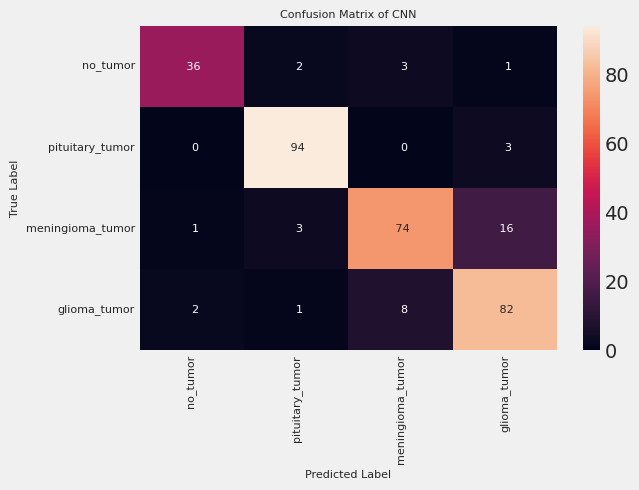

In [40]:
plt.figure(figsize=(6, 4))
heatmap_cnn = sns.heatmap(confusion_matrix(y_true_test,y_pred_test_cnn), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix of CNN',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [41]:
class_report_cnn = classification_report(y_true_test, y_pred_test_cnn, target_names=classes)
print("Classification Report of CNN:")
print(class_report_cnn)

Classification Report of CNN:
                  precision    recall  f1-score   support

        no_tumor       0.92      0.86      0.89        42
 pituitary_tumor       0.94      0.97      0.95        97
meningioma_tumor       0.87      0.79      0.83        94
    glioma_tumor       0.80      0.88      0.84        93

        accuracy                           0.88       326
       macro avg       0.88      0.87      0.88       326
    weighted avg       0.88      0.88      0.88       326



# **Inception V3**

In [37]:
iv3 = InceptionV3(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

x = GlobalAveragePooling2D()(iv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

output_tensor_iv3 = Dense(len(classes), activation='softmax')(x)

# Créer le modèle
InceptionV3_model = Model(inputs=iv3.input, outputs=output_tensor_iv3)

# Compiler le modèle
InceptionV3_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

# Afficher le résumé du modèle
InceptionV3_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │         96 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 110, 110,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 110,  │         96 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 110, 110,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 110, 110,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 110, 110,  │        192 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 110, 110,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d_5[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 22,853,924 (87.18 MB)

 Trainable params: 22,819,492 (87.05 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [38]:
reduce_lr_iv3 = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=0.0001, verbose=1)  
# early_stop_iv3 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) 
checkpoint_iv3 = ModelCheckpoint(filepath='best_InceptionV3Model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

In [39]:
# Train the model
start_time_iv3 = time.time()
InceptionV3_history = InceptionV3_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr_iv3, checkpoint_iv3],
    verbose=1
)
end_time_iv3 = time.time()

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.6502 - loss: 0.9978 - precision_1: 0.7180 - recall_1: 0.5526
Epoch 1: val_accuracy improved from -inf to 0.27676, saving model to best_InceptionV3Model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - accuracy: 0.6515 - loss: 0.9944 - precision_1: 0.7192 - recall_1: 0.5542 - val_accuracy: 0.2768 - val_loss: 16.5033 - val_precision_1: 0.2799 - val_recall_1: 0.2752 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8725 - loss: 0.4244 - precision_1: 0.9039 - recall_1: 0.8360
Epoch 2: val_accuracy improved from 0.27676 to 0.78287, saving model to best_InceptionV3Model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 26s 336ms/step - accuracy: 0.8726 - loss: 0.4239 - precision_1: 0.9039 - recall_1: 0.8362 - val_accuracy: 0.7829 - val_loss: 0.9535 - val_precision_1: 0.8182 - val_recall_1: 0.7569 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9020 - loss: 0.3193 

In [42]:
runtime_iv3 = end_time_iv3 - start_time_iv3

hours_iv3 = int(runtime_iv3 / 3600)
minutes_iv3 = int((runtime_iv3 % 3600) / 60)
seconds_iv3 = int(runtime_iv3 % 60)

print("Total runtime:", hours_iv3, "hours,", minutes_iv3, "minutes,", seconds_iv3, "seconds")

Total runtime: 0 hours, 14 minutes, 41 seconds


In [43]:
InceptionV3_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1', 'learning_rate'])

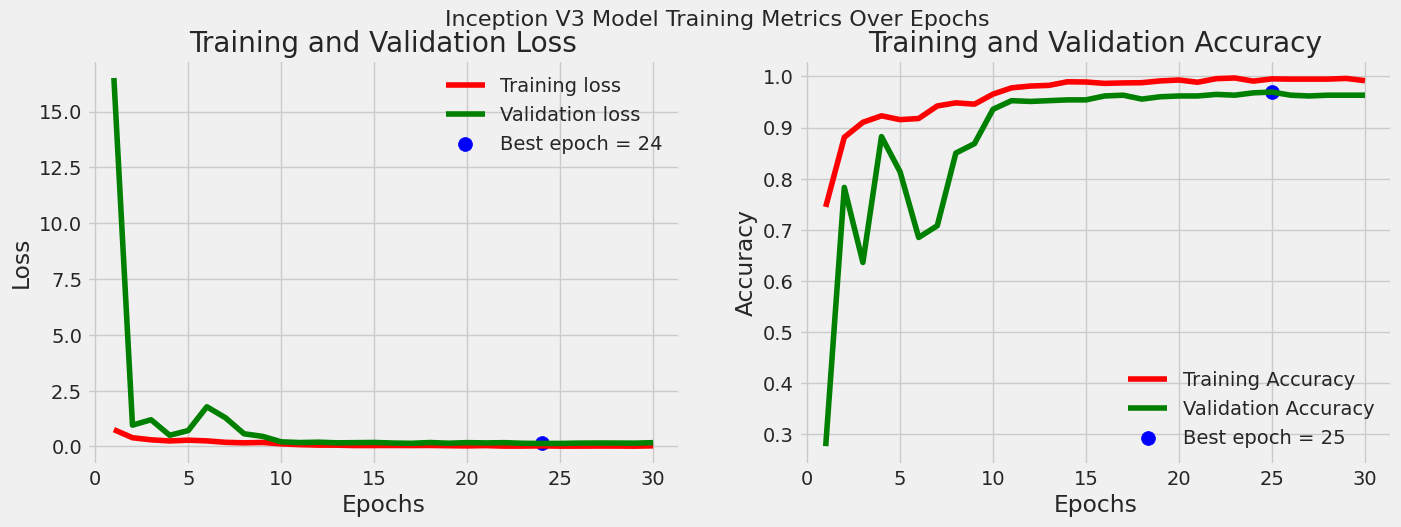

In [45]:
tr_acc_iv3 = InceptionV3_history.history['accuracy']
tr_loss_iv3 = InceptionV3_history.history['loss']
val_acc_iv3 = InceptionV3_history.history['val_accuracy']
val_loss_iv3 = InceptionV3_history.history['val_loss']

index_loss_iv3 = np.argmin(val_loss_iv3)
val_lowest_iv3 = val_loss_iv3[index_loss_iv3]
index_acc_iv3 = np.argmax(val_acc_iv3)
acc_highest_iv3 = val_acc_iv3[index_acc_iv3]

Epochs = [i + 1 for i in range(len(tr_acc_iv3))]
loss_label_iv3 = f'Best epoch = {str(index_loss_iv3 + 1)}'
acc_label_iv3 = f'Best epoch = {str(index_acc_iv3 + 1)}'

plt.figure(figsize=(15, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss_iv3, 'r', label='Training loss')
plt.plot(Epochs, val_loss_iv3, 'g', label='Validation loss')
plt.scatter(index_loss_iv3 + 1, val_lowest_iv3, s=100, c='blue', label=loss_label_iv3)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc_iv3, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc_iv3, 'g', label='Validation Accuracy')
plt.scatter(index_acc_iv3 + 1, acc_highest_iv3, s=100, c='blue', label=acc_label_iv3)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('Inception V3 Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [46]:
train_result_iv3 = InceptionV3_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result_iv3[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result_iv3[1] * 100))
print("Train Precision: {:.2f}%".format(train_result_iv3[2] * 100))
print("Train Recall: {:.2f}%".format(train_result_iv3[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9966 - loss: 0.0101 - precision_1: 0.9966 - recall_1: 0.9966
Train Loss: 1.22%
Train Accuracy: 99.61%
Train Precision: 99.61%
Train Recall: 99.61%


In [47]:
validation_results_iv3 = InceptionV3_model.evaluate(X_val,Y_val)

print("Test Loss: {:.2f}%".format(validation_results_iv3[0] * 100))
print("Test Accuracy: {:.2f}%".format(validation_results_iv3[1] * 100))
print("Test Precision: {:.2f}%".format(validation_results_iv3[2] * 100))
print("Test Recall: {:.2f}%".format(validation_results_iv3[3] * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.9765 - loss: 0.1105 - precision_1: 0.9765 - recall_1: 0.9765
Test Loss: 16.76%
Test Accuracy: 96.33%
Test Precision: 96.33%
Test Recall: 96.33%


In [48]:
predictions_iv3 = InceptionV3_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1) 
y_pred_test_iv3 = np.argmax(predictions_iv3, axis=1) 

accuracy_iv3 = accuracy_score(y_true_test, y_pred_test_iv3)
print("Accuracy:{:.2f}%".format(accuracy_iv3 * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 11s 716ms/step
Accuracy:95.71%


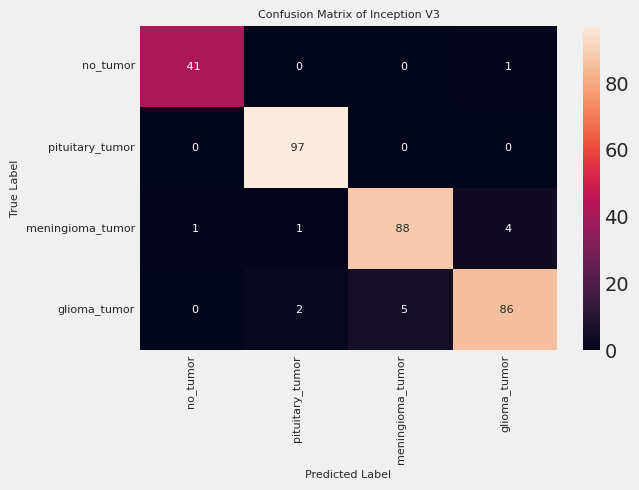

In [49]:
plt.figure(figsize=(6, 4))
heatmap_iv3 = sns.heatmap(confusion_matrix(y_true_test,y_pred_test_iv3), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix of Inception V3',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [50]:
class_report_iv3 = classification_report(y_true_test, y_pred_test_iv3, target_names=classes)
print("Classification Report of Inception V3:")
print(class_report_iv3)

Classification Report of Inception V3:
                  precision    recall  f1-score   support

        no_tumor       0.98      0.98      0.98        42
 pituitary_tumor       0.97      1.00      0.98        97
meningioma_tumor       0.95      0.94      0.94        94
    glioma_tumor       0.95      0.92      0.93        93

        accuracy                           0.96       326
       macro avg       0.96      0.96      0.96       326
    weighted avg       0.96      0.96      0.96       326



# **DenseNet**

In [51]:
dn = DenseNet121(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

x = GlobalAveragePooling2D()(dn.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

output_tensor_dn = Dense(len(classes), activation='softmax')(x)

DenseNet_model = Model(inputs=dn.input, outputs=output_tensor_dn)

DenseNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

DenseNet_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 231, 231,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 113, 113,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 113, 113,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 113, 113,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 115, 115,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 57, 57,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 57, 57,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 57, 57,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 57, 57,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 57, 57,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 57, 57,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 57, 57,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 57, 57,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 57, 57,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 57, 57,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 57, 57,    │     12,288 │ conv2_block2_0_r

 Total params: 7,564,356 (28.86 MB)

 Trainable params: 7,480,708 (28.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [52]:
reduce_lr_dn = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=0.0001, verbose=1) 
# early_stop_dn = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) 
checkpoint_dn = ModelCheckpoint(filepath='best_DenseNet121Model.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

In [53]:
# Train the model
start_time_dn = time.time()
DenseNet_history = DenseNet_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr_dn, checkpoint_dn],
    verbose=1
)
end_time_dn = time.time()

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6904 - loss: 0.9002 - precision_2: 0.7280 - recall_2: 0.6417
Epoch 1: val_accuracy improved from -inf to 0.39755, saving model to best_DenseNet121Model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.6914 - loss: 0.8971 - precision_2: 0.7289 - recall_2: 0.6428 - val_accuracy: 0.3976 - val_loss: 5.3864 - val_precision_2: 0.4034 - val_recall_2: 0.3960 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8327 - loss: 0.4397 - precision_2: 0.8562 - recall_2: 0.8036
Epoch 2: val_accuracy improved from 0.39755 to 0.49388, saving model to best_DenseNet121Model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 393ms/step - accuracy: 0.8331 - loss: 0.4389 - precision_2: 0.8565 - recall_2: 0.8040 - val_accuracy: 0.4939 - val_loss: 4.9874 - val_precision_2: 0.4954 - val_recall_2: 0.4908 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.9010 - loss: 0.3056 - pr

In [54]:
runtime_dn = end_time_dn - start_time_dn
hours_dn = int(runtime_dn / 3600)
minutes_dn = int((runtime_dn % 3600) / 60)
seconds_dn = int(runtime_dn % 60)

print("Total runtime:", hours_dn, "hours,", minutes_dn, "minutes,", seconds_dn, "seconds")

Total runtime: 0 hours, 19 minutes, 9 seconds


In [55]:
DenseNet_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_loss', 'val_precision_2', 'val_recall_2', 'learning_rate'])

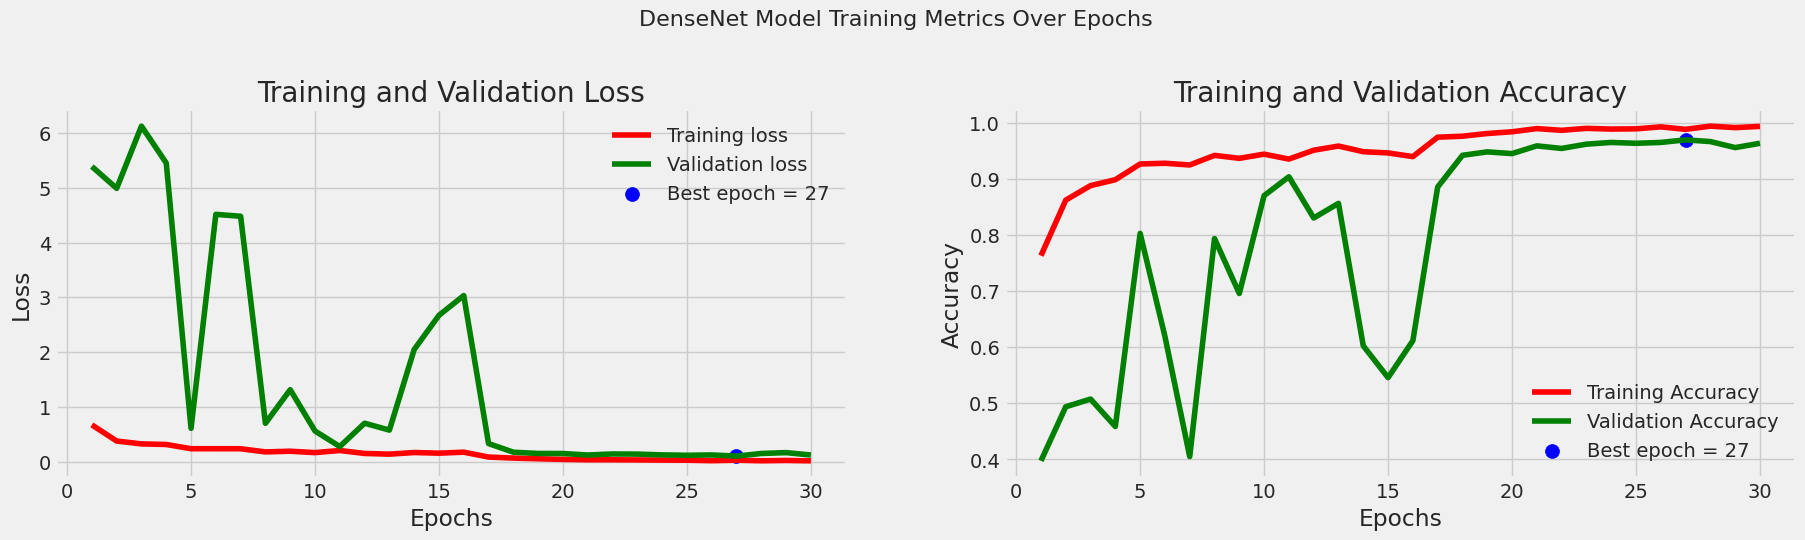

In [60]:
tr_acc_dn = DenseNet_history.history['accuracy']
tr_loss_dn = DenseNet_history.history['loss']
val_acc_dn = DenseNet_history.history['val_accuracy']
val_loss_dn = DenseNet_history.history['val_loss']

index_loss_dn = np.argmin(val_loss_dn)
val_lowest_dn = val_loss_dn[index_loss_dn]
index_acc_dn = np.argmax(val_acc_dn)
acc_highest_dn = val_acc_dn[index_acc_dn]


Epochs = [i + 1 for i in range(len(tr_acc_dn))]
loss_label_dn = f'Best epoch = {str(index_loss_dn + 1)}'
acc_label_dn = f'Best epoch = {str(index_acc_dn + 1)}'


plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_dn, 'r', label='Training loss')
plt.plot(Epochs, val_loss_dn, 'g', label='Validation loss')
plt.scatter(index_loss_dn + 1, val_lowest_dn, s=100, c='blue', label=loss_label_dn)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_dn, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc_dn, 'g', label='Validation Accuracy')
plt.scatter(index_acc_dn + 1, acc_highest_dn, s=100, c='blue', label=acc_label_dn)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('DenseNet Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [61]:
train_result_dn = DenseNet_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result_dn[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result_dn[1] * 100))
print("Train Precision: {:.2f}%".format(train_result_dn[2] * 100))
print("Train Recall: {:.2f}%".format(train_result_dn[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.9972 - loss: 0.0095 - precision_2: 0.9972 - recall_2: 0.9972
Train Loss: 1.07%
Train Accuracy: 99.74%
Train Precision: 99.74%
Train Recall: 99.69%


In [62]:
validation_results_dn = DenseNet_model.evaluate(X_val,Y_val)

print("Test Loss: {:.2f}%".format(validation_results_dn[0] * 100))
print("Test Accuracy: {:.2f}%".format(validation_results_dn[1] * 100))
print("Test Precision: {:.2f}%".format(validation_results_dn[2] * 100))
print("Test Recall: {:.2f}%".format(validation_results_dn[3] * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.9663 - loss: 0.1091 - precision_2: 0.9715 - recall_2: 0.9663
Test Loss: 12.60%
Test Accuracy: 96.33%
Test Precision: 96.48%
Test Recall: 96.33%


In [63]:
predictions_dn = DenseNet_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1) 
y_pred_test_dn = np.argmax(predictions_dn, axis=1)

accuracy_dn = accuracy_score(y_true_test, y_pred_test_dn)
print("Accuracy:{:.2f}%".format(accuracy_dn * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Accuracy:96.63%


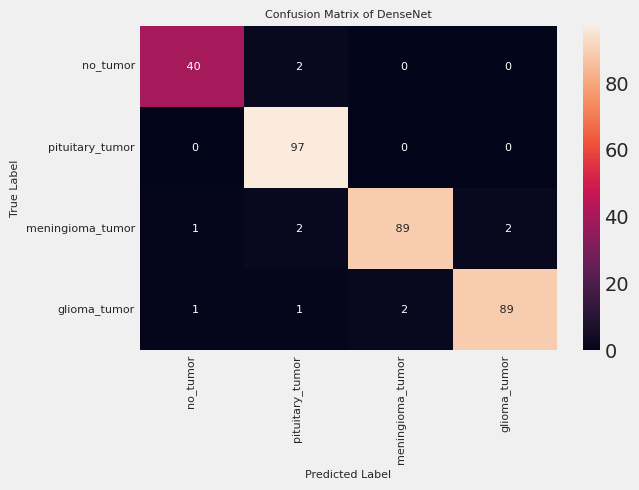

In [64]:
plt.figure(figsize=(6, 4))
heatmap_dn = sns.heatmap(confusion_matrix(y_true_test,y_pred_test_dn), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix of DenseNet',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [65]:
class_report_dn = classification_report(y_true_test, y_pred_test_dn, target_names=classes)
print("Classification Report of DenseNet:")
print(class_report_dn)

Classification Report of DenseNet:
                  precision    recall  f1-score   support

        no_tumor       0.95      0.95      0.95        42
 pituitary_tumor       0.95      1.00      0.97        97
meningioma_tumor       0.98      0.95      0.96        94
    glioma_tumor       0.98      0.96      0.97        93

        accuracy                           0.97       326
       macro avg       0.96      0.96      0.96       326
    weighted avg       0.97      0.97      0.97       326



# **EfficientNet**

In [66]:
base_model = EfficientNetB0(include_top=False,
                      input_shape=shape,
                      weights='imagenet')

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)

output_tensor = Dense(len(classes), activation='softmax')(x)

EfficientNet_model = Model(inputs=base_model.input, outputs=output_tensor)

EfficientNet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy', Precision(), Recall()])

EfficientNet_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 225, 225,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 225, 225,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 227, 227,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 113, 113,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 113, 113,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 113, 113,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 113, 113,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 113, 113,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 113, 113,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 113, 113,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 113, 113,  │        512 │ block1a_se_excit

 Total params: 4,707,495 (17.96 MB)

 Trainable params: 4,665,472 (17.80 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [67]:
reduce_lr_en = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_delta=0.0001, verbose=1) 
#early_stop_en = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1) 
checkpoint_en = ModelCheckpoint(filepath='best_EfficientNetModel.keras', monitor='val_accuracy', save_best_only=True, verbose=1) 

In [68]:
# Train the model
start_time_en = time.time()
EfficientNet_history = EfficientNet_model.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (X_val, Y_val),
    callbacks=[reduce_lr_en, checkpoint_en],
    verbose=1
)
end_time_en = time.time()

Epoch 1/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 866ms/step - accuracy: 0.7071 - loss: 0.7287 - precision_3: 0.7723 - recall_3: 0.5960
Epoch 1: val_accuracy improved from -inf to 0.18196, saving model to best_EfficientNetModel.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.7086 - loss: 0.7258 - precision_3: 0.7735 - recall_3: 0.5983 - val_accuracy: 0.1820 - val_loss: 2.1542 - val_precision_3: 0.1820 - val_recall_3: 0.1820 - learning_rate: 0.0010
Epoch 2/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9012 - loss: 0.2624 - precision_3: 0.9118 - recall_3: 0.8928
Epoch 2: val_accuracy did not improve from 0.18196
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 293ms/step - accuracy: 0.9012 - loss: 0.2624 - precision_3: 0.9119 - recall_3: 0.8929 - val_accuracy: 0.1820 - val_loss: 12.5049 - val_precision_3: 0.1820 - val_recall_3: 0.1820 - learning_rate: 0.0010
Epoch 3/30
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9356 - loss: 0.2020 - precision_3: 0.9409 - recall_3: 0.9299
Epoch 3

In [69]:
runtime_en = end_time_en - start_time_en
# Convertir le temps total en heures, minutes et secondes
hours_en = int(runtime_en / 3600)
minutes_en = int((runtime_en % 3600) / 60)
seconds_en = int(runtime_en % 60)

print("Total runtime:", hours_en, "hours,", minutes_en, "minutes,", seconds_en, "seconds")

Total runtime: 0 hours, 13 minutes, 59 seconds


In [70]:
EfficientNet_history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_3', 'recall_3', 'val_accuracy', 'val_loss', 'val_precision_3', 'val_recall_3', 'learning_rate'])

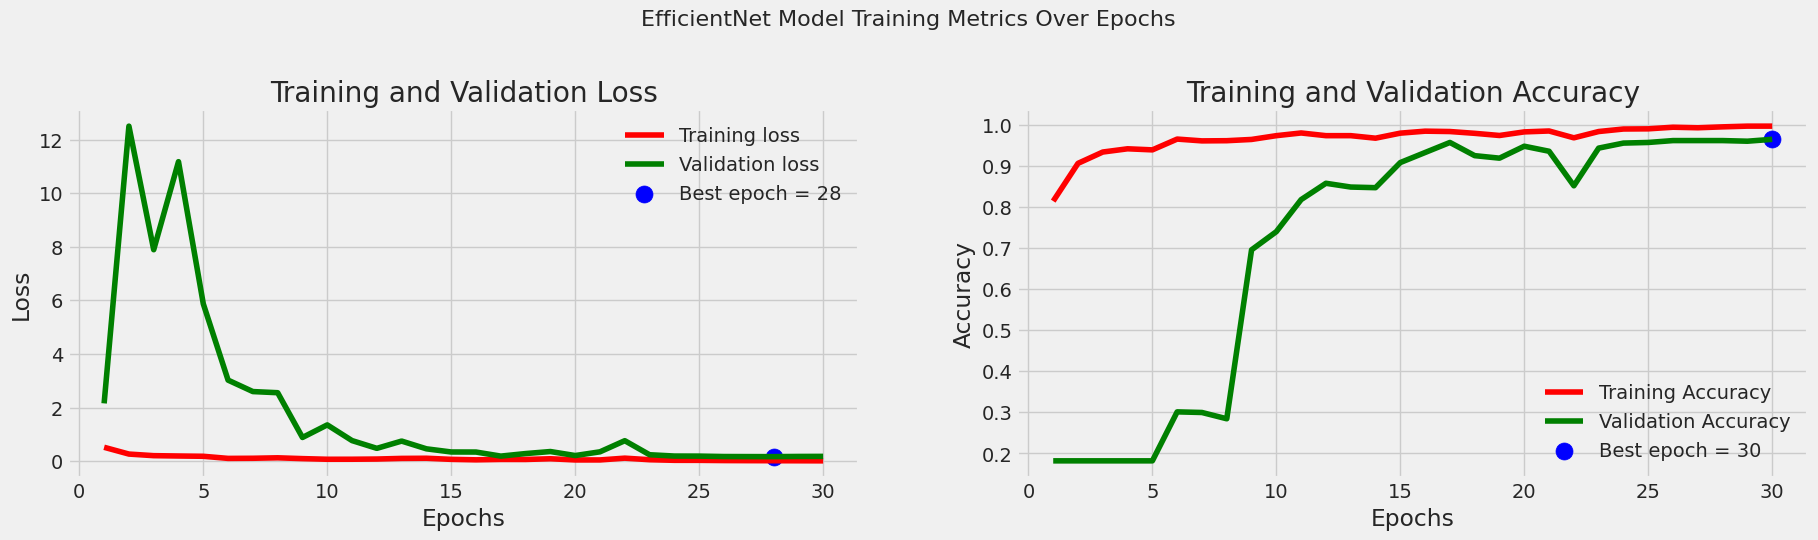

In [74]:
tr_acc_en = EfficientNet_history.history['accuracy']
tr_loss_en = EfficientNet_history.history['loss']
val_acc_en = EfficientNet_history.history['val_accuracy']
val_loss_en = EfficientNet_history.history['val_loss']

index_loss_en = np.argmin(val_loss_en)
val_lowest_en = val_loss_en[index_loss_en]
index_acc_en = np.argmax(val_acc_en)
acc_highest_en = val_acc_en[index_acc_en]


Epochs = [i + 1 for i in range(len(tr_acc_en))]
loss_label_en = f'Best epoch = {str(index_loss_en + 1)}'
acc_label_en = f'Best epoch = {str(index_acc_en + 1)}'

plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')

plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss_en, 'r', label='Training loss')
plt.plot(Epochs, val_loss_en, 'g', label='Validation loss')
plt.scatter(index_loss_en + 1, val_lowest_en, s=150, c='blue', label=loss_label_en)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc_en, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc_en, 'g', label='Validation Accuracy')
plt.scatter(index_acc_en + 1, acc_highest_en, s=150, c='blue', label=acc_label_en)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('EfficientNet Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [75]:
train_result_en = EfficientNet_model.evaluate(X_train,Y_train)

print("Train Loss: {:.2f}%".format(train_result_en[0] * 100))
print("Train Accuracy: {:.2f}%".format(train_result_en[1] * 100))
print("Train Precision: {:.2f}%".format(train_result_en[2] * 100))
print("Train Recall: {:.2f}%".format(train_result_en[3] * 100))

72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.9983 - loss: 0.0038 - precision_3: 0.9983 - recall_3: 0.9983
Train Loss: 0.54%
Train Accuracy: 99.74%
Train Precision: 99.74%
Train Recall: 99.74%


In [80]:
validation_results_en = EfficientNet_model.evaluate(X_val,Y_val)

print("Test Loss: {:.2f}%".format(validation_results_en[0] * 100))
print("Test Accuracy: {:.2f}%".format(validation_results_en[1] * 100))
print("Test Precision: {:.2f}%".format(validation_results_en[2] * 100))
print("Test Recall: {:.2f}%".format(validation_results_en[3] * 100))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9726 - loss: 0.1364 - precision_3: 0.9726 - recall_3: 0.9726
Test Loss: 17.59%
Test Accuracy: 96.48%
Test Precision: 96.48%
Test Recall: 96.48%


In [77]:
predictions_en = EfficientNet_model.predict(X_test)
y_true_test = np.argmax(Y_test, axis=1) 
y_pred_test_en = np.argmax(predictions_en, axis=1) 

accuracy_en = accuracy_score(y_true_test, y_pred_test_en)
print("Accuracy:{:.2f}%".format(accuracy_en * 100))

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 465ms/step
Accuracy:96.93%


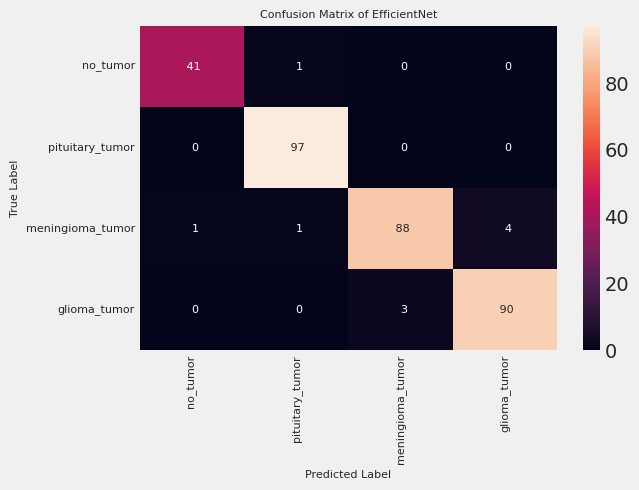

In [78]:
plt.figure(figsize=(6, 4))
heatmap_en = sns.heatmap(confusion_matrix(y_true_test,y_pred_test_en), annot=True, fmt='3g',
                      xticklabels=classes, yticklabels=classes, annot_kws={"size": 8})

plt.title('Confusion Matrix of EfficientNet',fontsize=8)
plt.xlabel('Predicted Label',fontsize=8)
plt.ylabel('True Label',fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

In [79]:
class_report_en = classification_report(y_true_test, y_pred_test_en, target_names=classes)
print("Classification Report of EfficientNet:")
print(class_report_en)

Classification Report of EfficientNet:
                  precision    recall  f1-score   support

        no_tumor       0.98      0.98      0.98        42
 pituitary_tumor       0.98      1.00      0.99        97
meningioma_tumor       0.97      0.94      0.95        94
    glioma_tumor       0.96      0.97      0.96        93

        accuracy                           0.97       326
       macro avg       0.97      0.97      0.97       326
    weighted avg       0.97      0.97      0.97       326



In [81]:
from tabulate import tabulate

# Create a dictionary with model names and accuracies
data = {
    "Model": ["CNN", "Inception V3", "DenseNet", "EfficientNet"],
    "Training Accuracy (%)": [train_result_cnn[1] * 100,train_result_iv3[1] * 100, train_result_dn[1] * 100,train_result_en[1] * 100],
    "Validation Accuracy (%)": [validation_results_cnn[1] * 100,validation_results_iv3[1] * 100, validation_results_dn[1] * 100,validation_results_en[1] * 100],
    "Test Accuracy (%)": [accuracy_cnn * 100, accuracy_iv3 * 100, accuracy_dn * 100,accuracy_en * 100],
}

# Convert the dictionary into a DataFrame
results_df = pd.DataFrame(data)

# Round the accuracy values to 2 decimal places
results_df = results_df.round({"Training Accuracy (%)": 2, "Validation Accuracy (%)": 2, "Test Accuracy (%)": 2})

# Print the table 
print("Model Evaluation Results:")
print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

Model Evaluation Results:
╒══════════════╤═════════════════════════╤═══════════════════════════╤═════════════════════╕
│ Model        │   Training Accuracy (%) │   Validation Accuracy (%) │   Test Accuracy (%) │
╞══════════════╪═════════════════════════╪═══════════════════════════╪═════════════════════╡
│ CNN          │                   92.6  │                     85.78 │               87.73 │
├──────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ Inception V3 │                   99.61 │                     96.33 │               95.71 │
├──────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ DenseNet     │                   99.74 │                     96.33 │               96.63 │
├──────────────┼─────────────────────────┼───────────────────────────┼─────────────────────┤
│ EfficientNet │                   99.74 │                     96.48 │               96.93 │
╘══════════════╧═════════════════════════╧══